Dataset contains Reviews of movies and a binary classification of the movies as output. The words of the reviews are indices of a dictionary.

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

/Users/franzi/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /Users/franzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/franzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from keras.datasets import imdb

num_words = 1000
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words + 1,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [3]:
# the word_index starts with number 1 and has 88584 entries in total, no number/value is missing

word_index = imdb.get_word_index()

print np.min(word_index.values())
print np.max(word_index.values())
print len(word_index.values())

1
88584
88584


In [4]:
# somehow number 3 is missing in x_train
print np.where(np.concatenate(x_train) == 3)
ix_3 = np.where(np.array(word_index.values()) == 3)[0][0]

print word_index.keys()[ix_3]

(array([], dtype=int64),)
a


In [5]:
print np.max(np.concatenate(x_train))
print np.min(np.concatenate(x_train))
print len(np.unique(np.concatenate(x_train)))

1000
1
999


In [6]:
#one-hot encoding of sentences
tokenizer = Tokenizer(num_words=num_words + 1)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

In [7]:
print x_train.shape

(25000, 1001)


In [8]:
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
# preparation of embedding layer

embeddings_index = {}
f = open(os.path.join('glove.6B', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
#get the dictionary with the word indices

word_index = imdb.get_word_index()

ix_common_words = np.where(np.array(word_index.values()) <= num_words)
keys_common_words = np.array(word_index.keys())[ix_common_words]
values_common_words = np.array(word_index.values())[ix_common_words]

most_common_words = dict()

for i, keys in enumerate(keys_common_words):
    most_common_words[keys] = values_common_words[i]

In [11]:
len(most_common_words.values())

1000

In [12]:
## get rid of first column, since index 0 is not present in word index
#x_train = x_train[:,1:]
#x_test = x_test[:,1:]

In [13]:
EMBEDDING_DIM = 100
num_words = 1000

new_word_index = most_common_words

embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
for word, i in new_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [30]:
from sklearn.manifold import TSNE

x_train_embedded = np.dot(x_train, embedding_matrix)

x_train_embedded_2D = TSNE(n_components=2).fit_transform(x_train_embedded)

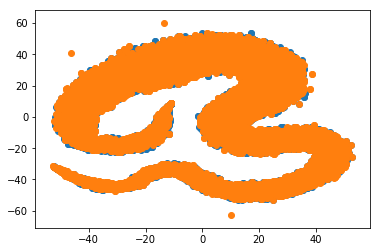

In [46]:
x_val = x_train_embedded_2D[:,0]
y_val = x_train_embedded_2D[:,1]

ix_class1 = np.where(y_train[:,0] == 0)[0]
ix_class2 = np.where(y_train[:,0] == 1)[0]

plt.scatter(x_val[ix_class1], y_val[ix_class1])
plt.scatter(x_val[ix_class2], y_val[ix_class2])

In [15]:
len(new_word_index)

1000

In [16]:
MAX_SEQUENCE_LENGTH = x_train.shape[1]

embedding_layer = Embedding(len(new_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [27]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D

model = Sequential()
model.add(embedding_layer)

#model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))

model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1001, 100)         100100    
_________________________________________________________________
dense_7 (Dense)              (None, 1001, 128)         12928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128128)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 256258    
Total params: 369,286
Trainable params: 269,186
Non-trainable params: 100,100
_________________________________________________________________
None


In [28]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=2, batch_size=128)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 146s 6ms/step - loss: 0.3820 - acc: 0.8278 - val_loss: 0.3292 - val_acc: 0.8593
Epoch 2/2
25000/25000 [==============================] - 137s 5ms/step - loss: 0.3348 - acc: 0.8597 - val_loss: 0.3283 - val_acc: 0.8593
